# Error computation with HESSE and MINOS

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first. 

iminuit (and C++ MINUIT) offers two major ways of computing parameter uncertainties from the cost function (which must be of least-squares form or negative log-likelihood), HESSE and MINOS. These have different pros and cons, on which we already touched in the basic tutorial. Here we want to go a bit deeper into the pros and cons and also try to reveal a bit of the math behind the two approaches.

There are several sources which explain what HESSE and MINOS do, in particular the MINUIT User's Guide (linked from the [iminuit documentation](https://iminuit.readthedocs.io/en/latest/about.html)). The mathematical details are covered in F. James, "Statistical Methods in Experimental Physics", 2nd edition, World Scientific (2006).

## Definitions

We need to use a couple of technical terms from mathematical statistics when talk about proven properties. We also use recurring variable names with the same meaning throughout.

* $n$ number of [observations](https://en.wikipedia.org/wiki/Sample_%28statistics%29)
* $x$ observation from data distribution $f(x; \theta)$ with parameter $\theta$ (not an angle!)
* $\hat \theta$ estimate of $\theta$ obtained from a sample (the parameter value obtained from the fit)
* $\mathcal L$ likelihood function
* $\mathcal I$ [Fisher information](https://en.wikipedia.org/wiki/Fisher_information)
* $E[\dots]$ expectation value of $\dots$ over distribution of $x$
* $V[\dots]$ variance of $\dots$

The terms **asymptotic** and **asymptotic limit** refer to inference from an infinite data sample. Mathematical properties of statistical methods are most commonly computed in this limit.

## HESSE

HESSE in a nutshell:
* Computes approximate covariance matrix $C_{ij}$ for all fitted parameters
* Square-root of diagonal elements of $C_{ij}$ corresponds to one standard deviation; to obtain $k$ standard deviations, multiply covariance matrix $C$ by $k^2$
* Can be used to form confidence intervals $\hat \theta_i \pm C_{ii}^{1/2}$
* Only way to obtain parameter correlations
* Comparably fast, requires:
    * Numerical computation of all second derivatives of the cost function (Hessian matrix)
    * Inverting this matrix
* Cannot compute uncertainty for only one parameter if there are several
* Approximately computed as by-product of MIGRAD algorithm (usually accurate enough when `strategy` >= 1 is used)

The algorithm derives its name from the Hessian matrix of second derivatives which is computed to obtain the uncertainties.

### How does it work?

The matrix of second derivatives of the cost function is computed for all free parameters and multiplied by 2. The result is inverted and multiplied by `errordef`.

MINUIT implements parameter limits by applying a variable transformation and therefore distinguishes internal and external parameter space. The Hessian matrix is computed in the internal parameter space and transformed using the chain rule to external space.

### Why does it work?

One can prove under general conditions in the asymptotic limit that a parameter estimate $\hat\theta$ obtained from the least-squares and the maximum-likelihood methods is normally distributed with minimum variance, given by the [Cramer-Rao lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound), which is the minimum for any unbiased estimator (these methods are asymptotically unbiased).

$$
V(\hat \theta) \underset{n\rightarrow \infty}{\longrightarrow} \left\{ n E\left[\left( \frac{\partial \ln\! f(x;\theta)}{\partial \theta} \right)^2 \right]_{\theta = \hat\theta} \right\}^{-1} = \left\{ -n E\left[\frac{\partial^2 \ln\! f(x;\theta)}{\partial \theta^2} \right]_{\theta = \hat\theta} \right\}^{-1}
$$

The expectation here is taken over the data distribution. Since the expectation value is constant, we see that the variance of $\hat\theta$ scales goes down with $n^{-1}$ in the asymptotic limit.

If the data range is independent of $\theta$, which we usually assume (but see F. James book for a counter example), we can swap integration over $x$ and differentiation with respect to $\theta$. Doing this and replacing the expectation with its plug-in estimate, the arithmetic average, we obtain:

$$
-n E\left[\frac{\partial^2 \ln\! f(x;\theta)}{\partial \theta^2} \right]_{\theta = \hat \theta} = -n \frac{1}{n} \sum_i \frac{\partial^2 \ln\! f(x_i; \theta)}{\partial \theta^2}\Big\vert_{\theta = \hat \theta} = \frac{\partial^2 \big(-\sum_i \ln\! f(x_i; \theta)\big)}{\partial \theta^2}\Big\vert_{\theta = \hat \theta}
$$

We now see that the numerator contains the negative log-likelihood  function that we often plug into iminuit. If there is a vector of parameters $\hat{\vec \theta}$, then this turns into the Hessian matrix of second derivatives.

#### A bit of history

So what about these factors of $2$ and `errordef` in MINUIT that were mentioned above? These don't appear here. There are historical reasons for those. In the asymptotic limit, the least-squares cost function that corresponds to the log-likelihood is $Q = -2 \ln\! \mathcal{L} - \text{constants}$. MINUIT was originally developed with least-squares fits in mind, therefore its internal math assumes the $Q$ form. If the second derivatives are computed from $Q$, the constants are removed but the Hessian must be multiplied by a factor of two to get the right variance. Correspondingly, if the user puts in a negative log-likelihood function, the same procedure now introduces an extra factor of two $2$, which must be compensated by the `errordef` value of 0.5 for the negative log-likelihood.

### Why is HESSE approximate

We started out from Cramer-Rao bound, the asymptotic limit for the parameter variance. How fast the finite sample approaches the limit depends on the problem at hand. For normal distributed data, the bound is exact.

We further approximated the computation of the bound by replacing the expectation over the likelihood with the sample mean of the likelihood. 

## MINOS

MINOS in a nutshell:

* Approximate confidence intervals (intervals are wrongly claimed to be "exact" in some sources, including the MINUIT paper from 1975)
* Cannot compute parameter correlations
* Some (unverified) sources claim better coverage probability than intervals based on HESSE
* In general slower than HESSE (requiring more function evaluations):
    * Iteratively computes the value pair $\theta^d, \theta^u$ which increases the cost function by `errordef` over the minimum
    * If the cost function has several parameters, it is minimised with respect to all other parameters during this scan
* Can be used to compute uncertainty for only one parameter - but this is not more efficient than HESSE, since the computation requires at least one evaluation of HESSE

The MINOS algorithm computes [profile-likelihood based](https://en.wikipedia.org/wiki/Likelihood_function#Profile_likelihood) confidence intervals.

### How does it work?

MINOS scans the likelihood along one parameter $\theta_i$,  while minimizing the likelihood with respect to all other parameters $\theta_k$ with $k \ne i$. This is effectively the same as expressing the other parameter estimates as a function of $\theta_i$, $\hat \theta_k(\theta_i)$, and scanning the now one-dimensional negative log-likelihood $-\ln \mathcal{L}(\theta_i; \theta_k = \hat \theta_k(\theta_i) , k\ne i)$. This is called the [profile likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Profile_likelihood) for parameter $\theta_i$.

One follows this curve until $-\ln \mathcal{L}$ increases by `errordef` with respect to its minimum and stores the two corresponding values $\theta^d_i$ and $\theta^u_i$. The interval $(\theta^d_i, \theta^u_i)$ has $68\,\%$ coverage probability in the asymptotic limit. In multi-dimensional parameter space, the computation is comparably expensive due to the iterative steps of scanning and minimization.

An efficient algorithm to compute the interval is described by Venzon and Moolgavkar in *A Method for Computing Profile-Likelihood-Based Confidence Intervals*, Journal of the Royal Statistical Society C37 (1988) 87–94 [DOI](https://doi.org/10.2307%2F2347496).

### Why does it work?

We define the likelihood ratio $\ell(\vec\theta) = \mathcal{L}(\vec\theta) / \mathcal{L}(\hat{\vec\theta})$. In the asymptotic limit, $-2 \ln \ell(\vec\theta)$ is $\chi^2(k)$ distributed, where $k$ is the number of fitted parameters. For $k = 1$, the $\chi^2$-interval $[0, 1)$ contains $68\,\%$ probability. For a single parameter fit therefore a corresponding interval is found by the two values $\theta^d$ and $\theta^u$ which solve

$$
-2\ln\ell(\theta) = 1 \Leftrightarrow -\ln\ell(\theta) = 1/2
$$

We recognize the difference in the negative log-likelihood on the left-hand side and our `errordef = 0.5` on the right-hand side. Confidence intervals with other coverage probability can be constructed by finding the corresponding upper value of the $\chi^2$-interval with that integrated probability. In a least-squares fit, we have

$$
\Delta Q(\theta) = -2 \ln \ell(\theta) = 1
$$

therefore `errordef = 1` is the crossing value for a least-squares cost function.

In the multi-parameter case, when we search for the interval for $\theta_i$, the other parameters are effectively fixed to their best-fit values for the current value $\theta_i$ in the scan, $\theta_k = \hat\theta_k(\theta_i)$. Therefore, during the scan they are not free. The profile likelihood is effectively a likelihood for a single parameter. Thus, $68\,\%$-intervals are also here obtained when the negative log-likelihood crosses the value $1/2$ above the minimum. 

### Why is MINOS approximate

In some sources, the MINOS intervals are wrongly described as *exact*. They are not exact, because for finite samples the intervals do not necessarily have $68\,\%$ coverage probability, only in the asymptotic limit.

Some sources claim that two approximations are involved in the HESSE calculation of an interval, but only one in the MINOS calculation and conclude that MINOS intervals therefore approach the asymptotic limit more rapidly. This claim is disputed by others.

# Coverage probability of HESSE and MINOS intervals in toy experiments

## Poisson distributed data

We construct HESSE and MINOS intervals for a counting experiment. We consider the extreme case of a single observation $k$ drawn from a Poisson distribution $P(k;\lambda)$. We use the maximum-likelihood method to find the best estimate for $\lambda$ for each $k$ under the constraint $\lambda > 0$, which is trivially just $\hat \lambda = k$, and construct intervals with the HESSE and MINOS algorithms to check their coverage.

This case can be fully handled analytically, but here we use iminuit's HESSE and MINOS algorithms to compute the intervals.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from argparse import Namespace
from iminuit import Minuit

<ipython-input-2-8dace5bca7e4>:12: RuntimeWarning: divide by zero encountered in log
  return lambd - k * np.log(lambd)
<ipython-input-2-8dace5bca7e4>:12: RuntimeWarning: invalid value encountered in double_scalars
  return lambd - k * np.log(lambd)


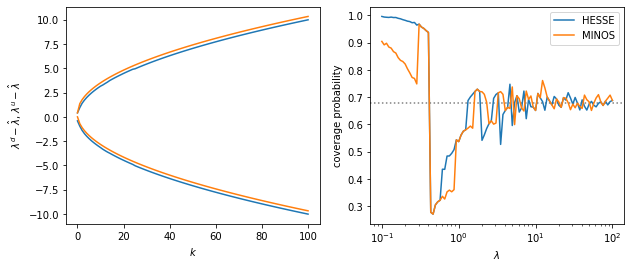

In [2]:
class MemoizedMinuit:
    """This class avoids repeated computation of the same intervals, which only depend on k."""

    def __init__(self):
        self._results = {}

    def __call__(self, k):
        r = self._results.get(k, None)
        if r is None:

            def nll(lambd):
                return lambd - k * np.log(lambd)

            m = Minuit(nll, lambd=k + 1)
            m.limits["lambd"] = (0, None)
            m.errordef = Minuit.LIKELIHOOD
            m.migrad()
            m.hesse()
            m.minos()
            assert m.valid

            p = m.values["lambd"]
            dp = m.errors["lambd"]
            pm = max(p + m.merrors["lambd"].lower, 0.0), p + m.merrors["lambd"].upper

            r = p, dp, *pm
            self._results[k] = r

        return r


rng = np.random.default_rng(seed=1)
nmc = 5000
mu = 10 ** np.linspace(-1, 2, 100)

m = MemoizedMinuit()

pcov = {
    "HESSE": np.empty_like(mu),
    "MINOS": np.empty_like(mu),
}

for i, mui in enumerate(mu):

    nh = 0
    nm = 0
    for imc in range(nmc):
        k = rng.poisson(mui)

        p, dp, pd, pu = m(k)

        if p - dp < mui < p + dp:
            nh += 1
        if pd < mui < pu:
            nm += 1

    pcov["HESSE"][i] = nh / nmc
    pcov["MINOS"][i] = nm / nmc

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(ax[0])
n = np.arange(101)
interval = {
    "HESSE": np.empty((len(n), 2)),
    "MINOS": np.empty((len(n), 2)),
}
for i, k in enumerate(n):
    p, dp, pd, pu = m(k)
    interval["HESSE"][i] = (p - dp, p + dp)
    interval["MINOS"][i] = (pd, pu)

for algo, vals in interval.items():
    plt.plot(n, vals[:, 0] - n, color="C0" if algo == "HESSE" else "C1", label=algo)
    plt.plot(n, vals[:, 1] - n, color="C0" if algo == "HESSE" else "C1", label=algo)
plt.xlabel("$k$")
plt.ylabel(r"$\lambda^d - \hat\lambda$, $\lambda^u - \hat\lambda$")

plt.sca(ax[1])
for algo, vals in pcov.items():
    plt.plot(mu, vals, label=algo)

plt.axhline(0.68, ls=":", color="0.5", zorder=0)
plt.xlabel(r"$\lambda$")
plt.ylabel("coverage probability")
plt.legend()
plt.semilogx();

In this special case, the intervals found by both methods are very close. The MINOS interval is identical to the HESSE interval up to a small almost constant shift. Visually, the rate of converge to the asymptotic coverage probability of 68% seems to be equal for both methods.

We can speak about the rate of convergence although we have drawn only a single observation from the Poisson pdf. The log-likelihood for $n$ observations with the same expectation is identical to the log-likelihood for one observation with an $n$-times higher expectation up to additive constants.

$$
\ln L = \sum_i^n (\lambda_i - k_i \ln \lambda_i)
= \lambda - \sum_i k_i (\ln \lambda - \ln n)
= \lambda - k \ln \lambda + k \ln n
$$

with $\sum_i^n \lambda_i = \lambda$, $\sum_i^n k_i = k$, and $\lambda_i = \lambda / n$. Therefore, the test cases with large values of $\lambda$ correspond to large observation samples with a small constant $\lambda$.

## Fit of transformed normally distributed data

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.122                      │              Nfcn = 168              │
│ EDM = 2.02e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,cx,0.11,0.06,-0.08,0.05,,,
1,cy,0.05,0.10,-0.11,0.08,,,


┌──────────┬───────────────────────┬───────────────────────┐
│          │          cx           │          cy           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.08   │   0.05    │   -0.11   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘

(-0.1, 0.2)

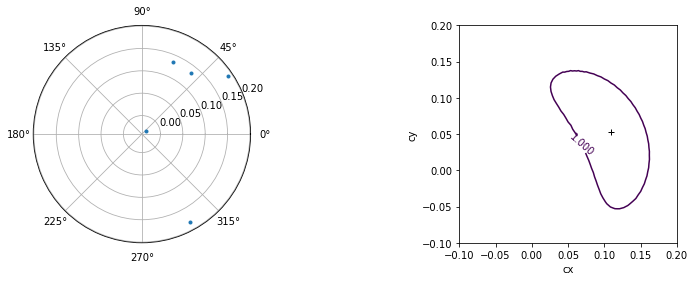

In [3]:
rng = np.random.default_rng(1)

truth = Namespace(cr=0.1, cphi=0, sr=0.1, sphi=2)
truth.cx = truth.cr * np.cos(truth.cphi)
truth.cy = truth.cr * np.sin(truth.cphi)

d_r = rng.normal(truth.cr, truth.sr, size=5)
d_phi = rng.normal(truth.cphi, truth.sphi, size=d_r.shape)

cov = np.eye(2)
cov[0, 0] = truth.sr ** 2
cov[1, 1] = truth.sphi ** 2


def nll(cx, cy):
    cr = np.linalg.norm((cx, cy))
    cphi = np.arctan2(cy, cx)
    return -np.sum(
        multivariate_normal((cr, cphi), cov).logpdf(np.transpose((d_r, d_phi)))
    )


m = Minuit(nll, cx=0.1, cy=0)
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
m.minos()
display(m.fmin, m.params)
display(m.merrors)

plt.figure(figsize=(14, 4))

plt.subplot(121, polar=True)
plt.plot(d_phi, d_r, ".")

plt.subplot(122, aspect="equal")
m.draw_mncontour("cx", "cy", nsigma=1, numpoints=100)
plt.plot(m.values["cx"], m.values["cy"], "+k")
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)

In [4]:
truth = Namespace(cr=0.1, cphi=0, sr=0.1, sphi=2)
truth.cx = truth.cr * np.cos(truth.cphi)
truth.cy = truth.cr * np.sin(truth.cphi)
truth.cov = np.eye(2)
truth.cov[0, 0] = truth.sr ** 2
truth.cov[1, 1] = truth.sphi ** 2

n_tries = 50  # increase this to 500 get smoother curves (running will take a while)
n_data = np.unique(np.geomspace(5, 100, 20, dtype=int))


def compute(n):
    rng = np.random.default_rng(seed=n)

    n_h = 0
    n_m = 0
    h_lus = []
    m_lus = []
    xs = []
    for i_try in range(n_tries):
        while True:
            d_r = rng.normal(truth.cr, truth.sr, size=n)
            d_phi = rng.normal(truth.cphi, truth.sphi, size=n)

            def nll(cx, cy):
                cr = np.linalg.norm((cx, cy))
                cphi = np.arctan2(cy, cx)
                return -np.sum(
                    multivariate_normal((cr, cphi), truth.cov).logpdf(
                        np.transpose((d_r, d_phi))
                    )
                )

            m = Minuit(nll, cx=0.1, cy=0)
            m.errordef = Minuit.LIKELIHOOD
            try:
                m.migrad()
                if not m.valid:
                    continue

                m.hesse()

                if not m.accurate:
                    continue

                m.minos("cx")
                if m.merrors["cx"].is_valid:
                    break

            except Exception as e:
                print(f"exception in n={n} i_try={i_try}")
                print(e)

        x = m.values["cx"]
        dx = m.errors["cx"]
        me = m.merrors["cx"]
        h_lu = x - dx, x + dx
        m_lu = x + me.lower, x + me.upper
        if h_lu[0] < truth.cx < h_lu[1]:
            n_h += 1
        if m_lu[0] < truth.cx < m_lu[1]:
            n_m += 1
        xs.append(x)
        h_lus.append(h_lu)
        m_lus.append(m_lu)

    x = np.mean(xs)
    h_l, h_u = np.mean(h_lus, axis=0)
    m_l, m_u = np.mean(m_lus, axis=0)
    return n_h, n_m, x, h_l, h_u, m_l, m_u


n_h, n_m, x, hl, hu, ml, mu = np.transpose([x for x in map(compute, n_data)])

h_pcov = n_h.astype(float) / n_tries
m_pcov = n_m.astype(float) / n_tries

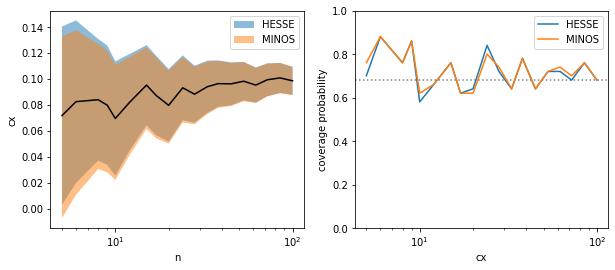

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.fill_between(n_data, hl, hu, alpha=0.5, label="HESSE")
plt.fill_between(n_data, ml, mu, alpha=0.5, label="MINOS")
plt.plot(n_data, x, "-k")
plt.legend()
plt.xlabel("n")
plt.ylabel("cx")
plt.semilogx()
plt.sca(ax[1])
plt.plot(n_data, h_pcov, label="HESSE")
plt.plot(n_data, m_pcov, label="MINOS")
plt.axhline(0.68, ls=":", color="0.5", zorder=0)
plt.xlabel(r"cx")
plt.ylabel("coverage probability")
plt.legend()
plt.ylim(0, 1)
plt.semilogx();